<h1>
    <img src="dataproc-jobs-logo.png" alt="drawing" width="50"/> 
    Dataproc usage analysis
</h1>

This sample demonstrates how to analyse Dataproc usage and billing. It uses the [JobController Python client](https://cloud.google.com/python/docs/reference/dataproc/latest/google.cloud.dataproc_v1.services.job_controller.JobControllerClient#google_cloud_dataproc_v1_services_job_controller_JobControllerClient_list_operations) to retrieve the service operations of type [dataproc.v1.ClusterOperationMetadata](https://cloud.google.com/python/docs/reference/dataproc/5.16.0/google.cloud.dataproc_v1.types.ClusterOperationMetadata). This operation logs cluster creation and deletion events. In addition, it uses the billing data exported in BigQuery to provide further insights about the usage cost.

#### Reference architecture implementation
![dataproc-jobs-architecture.png](dataproc-jobs-architecture.png)

Pre-requisites:
* [Billing export setup to BigQuery](https://cloud.google.com/billing/docs/how-to/export-data-bigquery)
* [Create a BigQuery dataset named **dataproc_analysis**](https://cloud.google.com/bigquery/docs/datasets#console)
* [BigQueryDataViewer role](https://cloud.google.com/bigquery/docs/access-control#dataset_level) at the Billing export dataset
* [BigQueryDataEditor role](https://cloud.google.com/bigquery/docs/access-control#dataset_level) at the **dataproc_analysis** dataset
* Dataproc [operations.list](https://cloud.google.com/dataproc/docs/concepts/iam/iam#operations_methods_required_permissions) and [workflowTemplates.list](https://cloud.google.com/dataproc/docs/concepts/iam/iam#workflow_templates_methods_required_permissions) IAM permissions

Considerations:
* This code will not retrieve nor ingest data incrementally, but historically. Then it will filter from the specified date.
* Tables will be re-created at each run
* Code provided as a sample, not ready to production. Review with your organization

### 1. Install upgrade dependencies

In [1]:
pip install google-cloud-dataproc

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade google-api-core

Note: you may need to restart the kernel to use updated packages.


### 2. Imports and variables

##### 2.1 RESTART KERNEL

In [3]:
from google.cloud import dataproc_v1 as dataproc
from google.api_core import client_options
from google.longrunning.operations_pb2 import ListOperationsRequest
from typing import Sequence, Tuple, Union
from google.protobuf.json_format import MessageToJson 
import json
import pandas as pd
from google.cloud import bigquery
import time

**2.2 Provide your own setup**

In [4]:
PROJECT_ID = "" # Your own GCP project ID
GCP_REGION = "us-central1" # Your region
BQ_BILLING_DATASET_NAME = "gcp_billing"
BQ_BILLING_TABLE_NAME = "gcp_billing_export_resource_v1_019CAE_7D7330_15385C"

# Set reporting start date 
START_DATE = "2024-03-01"

In [5]:
# Do not change, unless necesary
BQ_DATASET_NAME = "dataproc_analysis"
BQ_TABLE_NAME_RAW = "operations_raw"
BQ_TABLE_NAME_CLEAN = "operations_clean"
BQ_TABLE_NAME_MODEL = "operations_model"
BQ_BILLING_TABLE_VIEW = "billing_model"

In [6]:
client_options = client_options.ClientOptions(
    api_endpoint=f"{GCP_REGION}-dataproc.googleapis.com:443"
)
workflow_template_client = dataproc.WorkflowTemplateServiceClient(client_options=client_options)
bq_client = bigquery.Client()

In [7]:
def run_bq_query(sql_query):
    query_job = bq_client.query(sql_query)
    return query_job.result()

In [8]:
def save_to_bq(table_id, df, schema = None):
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_APPEND",
        schema = schema
    )

    job = bq_client.load_table_from_dataframe(df, table_id, job_config=job_config) 
    return job.result()

In [9]:
SQL_QUERY = f"""
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}
    (
        clusterUuid STRING,
        clusterName STRING,
        operationType STRING,
        status STRING,
        master_instances STRING,
        master_machine_type STRING,
        worker_instances STRING,
        worker_machine_type STRING
    );
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
    (
        clusterUuid STRING, 
        clusterName STRING,
        operationType STRING,
        stateStartTime STRING,
        master_instances STRING,
        master_machine_type STRING,
        worker_instances STRING,
        worker_machine_type STRING
    );
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
    (
        clusterUuid STRING, 
        clusterName STRING,
        created TIMESTAMP,
        deleted TIMESTAMP,
        date DATE,
        hour INTEGER,
        master_instances STRING,
        master_machine_type STRING,
        worker_instances STRING,
        worker_machine_type STRING,
        seconds_elapsed INTEGER,
    );
"""
run_bq_query(SQL_QUERY)

### 3. List workflow templates

In [10]:
parent = f"projects/{PROJECT_ID}/regions/{GCP_REGION}"
request = dataproc.ListWorkflowTemplatesRequest(parent=parent)

In [11]:
page_result = workflow_template_client.list_workflow_templates(request=request)

In [12]:
workflow_templates = []

for response in page_result:
    workflow_templates.append({
        "name": response.name,
        "id": response.id
    })

### 4. Get cluster operations and save them into BigQuery

In [13]:
def format_ops_data(ops):
    cluster_metadata = json.loads(MessageToJson(ops.metadata))
    ops = json.loads(MessageToJson(ops))
    
    response = ops.get("response", None)
    config = response.get("config", None) if response is not None else None

    # Master
    master_config = config.get("masterConfig", {"masterConfig": None}) if config is not None else None
    master_num_instances = master_config.get("numInstances", "") if master_config is not None else ""
    master_machineType = master_config.get("machineTypeUri", "") if master_config is not None else ""
    master_mathineType = master_machineType[master_machineType.rindex('/')+1:] if master_machineType != "" else ""

    # Worker
    worker_config = config.get("workerConfig", {"workerConfig": None}) if config is not None else None
    worker_num_instances = worker_config.get("numInstances", "") if worker_config is not None else ""
    worker_machineType = master_config.get("machineTypeUri", "") if worker_config is not None else ""
    worker_machineType = worker_machineType[worker_machineType.rindex('/')+1:] if worker_machineType != "" else ""
    
    return {
        "clusterName": cluster_metadata["clusterName"], 
        "clusterUuid": cluster_metadata["clusterUuid"], 
        "operationType": cluster_metadata["operationType"], 
        "status": cluster_metadata["status"],
        "master_instances": str(master_num_instances),
        "master_machine_type": master_mathineType,
        "worker_instances": str(worker_num_instances),
        "worker_machine_type": worker_machineType,
    }

In [14]:
def run_extract(filter_string):
    parent = f"projects/{PROJECT_ID}/regions/{GCP_REGION}/operations"
    operations_count = 0
    page_token = ""
    while True:
        time.sleep(0.5)
        operations = []
        request = ListOperationsRequest(
            name = parent,
            page_token = page_token,
            filter = filter_string
        )
        execution_request = workflow_template_client.list_operations(request=request)
        for ops in execution_request.operations:
            if ops.metadata.type_url == "type.googleapis.com/google.cloud.dataproc.v1.ClusterOperationMetadata":
                operations_count += 1
                cluster_metadata = format_ops_data(ops)
                operations.append(cluster_metadata)

        df = pd.DataFrame(operations)
        df["status"] = df["status"].apply(json.dumps)
        save_to_bq(
            table_id = f"{BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}",
            df = df
        )

        page_token = execution_request.next_page_token
        if page_token == '':
            return operations_count

In [15]:
operations_count = 0
filter_string = "operationType=CREATE"
operations_count += run_extract(filter_string)

filter_string = "operationType=DELETE"
operations_count += run_extract(filter_string)

In [16]:
f"{operations_count} operations found"

'86 operations found'

### 5. Clean operations

In [17]:
SQL_QUERY = f"""
    INSERT INTO {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
      WITH operations_clean AS (
        SELECT 
            clusterUuid
            , clusterName
            , operationType
            , JSON_VALUE(PARSE_JSON(status), '$.stateStartTime') stateStartTime
            , master_instances
            , master_machine_type
            , worker_instances
            , worker_machine_type
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}
          WHERE 
              --JSON_VALUE(PARSE_JSON(status), '$.innerState') = 'DONE'
              JSON_VALUE(PARSE_JSON(status), '$.state') = 'DONE'
      )
      , created AS (
        SELECT
            *
            , RANK() OVER ( PARTITION BY clusterUuid ORDER BY stateStartTime ASC) cluster_group
        FROM operations_clean 
        WHERE 
            operationType = 'CREATE'
            AND DATE(stateStartTime) >= DATE('{START_DATE}')
        GROUP BY ALL
        ORDER BY stateStartTime
      )
      , deleted AS (
        SELECT
        *
        , RANK() OVER ( PARTITION BY clusterUuid ORDER BY stateStartTime DESC ) cluster_group
        FROM operations_clean 
        WHERE operationType = 'DELETE' AND clusterUuid IN (SELECT clusterUuid FROM created GROUP BY 1)
        GROUP BY ALL
        ORDER BY stateStartTime
      )
      SELECT 
          * EXCEPT (cluster_group)
      FROM created
      WHERE cluster_group = 1
      UNION ALL
      SELECT 
          * EXCEPT (cluster_group)
      FROM deleted
      WHERE cluster_group = 1
"""
run_bq_query(SQL_QUERY)

### 6. Model cluster usage

In [18]:
SQL_QUERY = f"""
    INSERT INTO {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
        WITH cluster_create AS (
          SELECT 
              clusterUuid, clusterName, TIMESTAMP(stateStartTime) stateStartTime,
              master_instances, master_machine_type, worker_instances, worker_machine_type
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
          WHERE operationType = 'CREATE'
        )
        , cluster_delete AS (
          SELECT clusterUuid, TIMESTAMP(stateStartTime) stateStartTime
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
          WHERE operationType = 'DELETE'
        )
        SELECT 
            cluster_create.clusterUuid
          , cluster_create.clusterName
          , cluster_create.stateStartTime AS created
          , cluster_delete.stateStartTime AS deleted
          , extract(DATE from cluster_create.stateStartTime) date
          , extract(HOUR from cluster_create.stateStartTime) hour
          , master_instances
          , master_machine_type
          , worker_instances
          , worker_machine_type
          , TIMESTAMP_DIFF(cluster_delete.stateStartTime, cluster_create.stateStartTime, SECOND) AS seconds_elapsed
         FROM cluster_create
        LEFT JOIN cluster_delete
        USING (clusterUuid)
        GROUP BY 1,2,3,4,5,6,7,8,9,10
"""
run_bq_query(SQL_QUERY)

### 7. Visualize

#### 7.1 Total seconds by time

In [19]:
SQL_QUERY = f"""
    SELECT 
          date
        , hour
        , concat(date, ' ', hour, ':00') date_hour
        , sum(seconds_elapsed) / 60 minutes
    FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
    GROUP BY 1,2,3
    ORDER BY 3
"""
df = bq_client.query(SQL_QUERY).to_dataframe()

<Axes: xlabel='date_hour'>

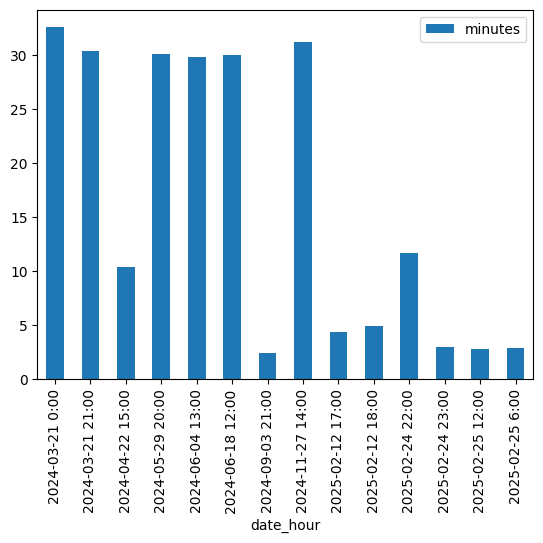

In [20]:
df.plot(kind="bar", x="date_hour", y="minutes")

#### 7.2 Cluster details

In [21]:
SQL_QUERY = f"""
SELECT 
      date
    , hour
    , clusterUuid
    , clusterName
    , seconds_elapsed / 60 minutes
FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
ORDER BY 1,2,3
"""
df = bq_client.query(SQL_QUERY).to_dataframe()

In [22]:
df.head()

,date,hour,clusterUuid,clusterName,minutes
0,2024-03-21,0,7c7f0f34-76e5-422b-9b10-27c319dea982,srvls-session-7ae4c720-8e54-477e-b33b-a9cecc62...,2.383333
1,2024-03-21,0,f177a280-8efc-42fe-885d-edc8ff76f64c,srvls-session-0b40ab36-883c-4ec1-93f5-43efb647...,30.166667
2,2024-03-21,21,199a2ebc-e287-40a8-a7e6-701042cd6663,srvls-session-8f4207ee-921a-4593-86b5-ead3d406...,30.366667
3,2024-04-22,15,08273726-b69e-488a-a813-c0e287b9bf0b,srvls-session-d6c9fdd2-b4d5-49ad-9853-fd283347...,10.366667
4,2024-05-29,20,fc36f463-6de5-4f4d-972a-7e7a0cccdaa0,srvls-session-d9f26ba6-6140-47f6-9f6d-c3c17da5...,30.066667


### 8. Billing information

#### 8.1 Total price

In [23]:
SQL_QUERY = f"""
    SELECT 
      CONCAT(
          EXTRACT (DATE FROM usage_start_time),
          ' ',
          EXTRACT (HOUR FROM usage_start_time),
          ' :00'
       ) date_hour,
      sku.id sku_id, 
      price.effective_price / price.pricing_unit_quantity effective_price,
      SUM(usage.amount_in_pricing_units) amount_in_pricing_units, 
      SUM(usage.amount_in_pricing_units * price.effective_price / price.pricing_unit_quantity) total_price
    FROM {BQ_BILLING_DATASET_NAME}.{BQ_BILLING_TABLE_NAME}
    WHERE 
      service.description = 'Dataproc' 
      AND sku.description LIKE 'Data Compute Unit (milli) Hours%'
      AND DATE(usage_start_time) >= DATE('{START_DATE}')
    GROUP BY 1,2,3
    ORDER BY 1
"""
df_billing = bq_client.query(SQL_QUERY).to_dataframe()

<Axes: xlabel='date_hour'>

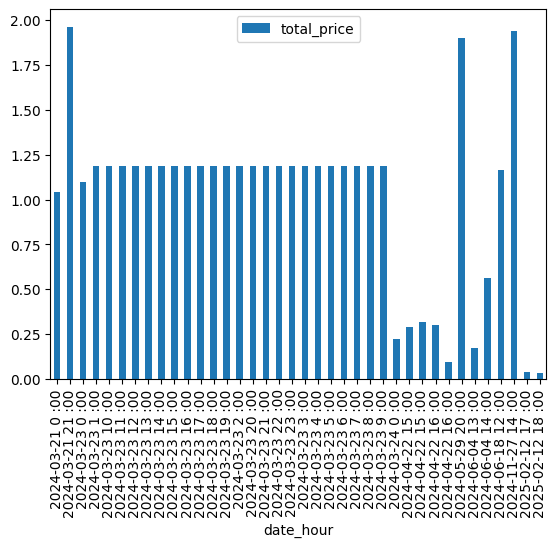

In [24]:
df_billing.plot(kind="bar", x="date_hour", y="total_price")

#### 8.2 Billing detail

In [25]:
SQL_QUERY = f"""
    CREATE OR REPLACE MATERIALIZED VIEW {BQ_DATASET_NAME}.{BQ_BILLING_TABLE_VIEW} AS
    SELECT 
      EXTRACT (DATE FROM usage_start_time) date,
      EXTRACT (HOUR FROM usage_start_time) hour,
      sku.id sku_id, 
      sku.description sku_description, 
      price.effective_price / price.pricing_unit_quantity effective_price,
      SUM(usage.amount_in_pricing_units) amount_in_pricing_units, 
      SUM(usage.amount_in_pricing_units * price.effective_price / price.pricing_unit_quantity) total_price
    FROM {BQ_BILLING_DATASET_NAME}.{BQ_BILLING_TABLE_NAME}
    WHERE 
      service.description = 'Dataproc' 
      AND sku.description LIKE 'Data Compute Unit (milli) Hours%'
      AND DATE(usage_start_time) >= DATE('{START_DATE}')
    GROUP BY 1,2,3,4,5;
    
    SELECT * FROM {BQ_DATASET_NAME}.{BQ_BILLING_TABLE_VIEW} ORDER BY 1,2;
"""
df_billing = bq_client.query(SQL_QUERY).to_dataframe()

In [26]:
df_billing.head(200)

,date,hour,sku_id,sku_description,effective_price,amount_in_pricing_units,total_price
0,2024-03-21,0,A486-6040-07FE,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000089000,11721.573333,1.043220
1,2024-03-21,21,A486-6040-07FE,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000089000,22043.298611,1.961854
2,2024-03-23,0,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,10963.938611,1.098937
3,2024-03-23,1,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11849.999167,1.187749
4,2024-03-23,2,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749
5,2024-03-23,3,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749
6,2024-03-23,4,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749
7,2024-03-23,5,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749
8,2024-03-23,6,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749
9,2024-03-23,7,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749


### 9. Visualize in Looker Studio

With the modeled tables generated in your dataset **dataproc_analysis** [operations_model, billing_,model], you can now generate the following dashboard in Looker Studio to provide business users visibility about Dataproc cluster usage and billing.

![dataproc-jobs.png](dataproc-jobs.png)